In [110]:
import numpy as np
from typing import Tuple, List, Optional, Callable
from dm_control import mjcf

from flygym.mujoco.util import load_config
from flygym.mujoco.arena import BaseArena



class MovOdorArena(BaseArena):
    """Flat terrain with an odor source.

    Attributes
    ----------
    root_element : mjcf.RootElement
        The root MJCF element of the arena.
    friction : Tuple[float, float, float]
        The sliding, torsional, and rolling friction coefficients of the
        ground, by default (1, 0.005, 0.0001)
    num_sensors : int
        The number of odor sensors, by default 4: 2 antennae + 2 maxillary
        palps.
    odor_source : np.ndarray
        The position of the odor source in (x, y, z) coordinates. The shape
        of the array is (n_sources, 3).
    peak_intensity : np.ndarray
        The peak intensity of the odor source. The shape of the array is
        (n_sources, n_dimensions). Note that the odor intensity can be
        multidimensional.
    num_odor_sources : int
        Number of odor sources.
    odor_dimensions : int
        Dimension of the odor space.
    diffuse_func : Callable
        The function that, given a distance from the odor source, returns
        the relative intensity of the odor. By default, this is a inverse
        square relationship.
    birdeye_cam : dm_control.mujoco.Camera
        MuJoCo camera that gives a birdeye view of the arena.
    birdeye_cam_zoom : dm_control.mujoco.Camera
         MuJoCo camera that gives a birdeye view of the arena, zoomed in
         toward the fly.

    Parameters
    ----------
    size : Tuple[float, float], optional
        The size of the arena in mm, by default (300, 300).
    friction : Tuple[float, float, float], optional
        The sliding, torsional, and rolling friction coefficients of the
        ground, by default (1, 0.005, 0.0001).
    num_sensors : int, optional
        The number of odor sensors, by default 4: 2 antennae + 2 maxillary
        palps.
    odor_source : np.ndarray, optional
        The position of the odor source in (x, y, z) coordinates. The shape
        of the array is (n_sources, 3).
    peak_intensity : np.ndarray, optional
        The peak intensity of the odor source. The shape of the array is
        (n_sources, n_dimensions). Note that the odor intensity can be
        multidimensional.
    diffuse_func : Callable, optional
        The function that, given a distance from the odor source, returns
        the relative intensity of the odor. By default, this is a inverse
        square relationship.
    marker_colors : List[Tuple[float, float, float, float]], optional
        A list of n_sources RGBA values (each as a tuple) indicating the
        colors of the markers indicating the positions of the odor sources.
        The RGBA values should be given in the range [0, 1]. By default,
        the matplotlib color cycle is used.
    marker_size : float, optional
        The size of the odor source markers, by default 0.25.
    """

    def __init__(
        self,
        size: Tuple[float, float] = (300, 300),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        num_sensors: int = 4,
        odor_source: np.ndarray = np.array([[10, 0, 0]]),
        peak_intensity: np.ndarray = np.array([[1]]),
        diffuse_func: Callable = lambda x: x**-2,
        marker_colors: Optional[List[Tuple[float, float, float, float]]] = None,
        marker_size: float = 0.25,
        move_speed=0.5,
        move_direction="right",
        
    ):
        self.root_element = mjcf.RootElement()
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(60, 60),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.friction = friction
        self.num_sensors = num_sensors
        self.odor_source = np.array(odor_source)
        self.peak_odor_intensity = np.array(peak_intensity)
        self.num_odor_sources = self.odor_source.shape[0]
        if self.odor_source.shape[0] != self.peak_odor_intensity.shape[0]:
            raise ValueError(
                "Number of odor source locations and peak intensities must match."
            )
        self.diffuse_func = diffuse_func

        # Add birdeye camera
        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(self.odor_source[:, 0].max() / 2, 0, 35),
            euler=(0, 0, 0),
            fovy=45,
        )
        self.birdeye_cam_zoom = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam_zoom",
            mode="fixed",
            pos=(11, 0, 29),
            euler=(0, 0, 0),
            fovy=45,
        )

        # Add markers at the odor sources
        if marker_colors is None:
            color_cycle_rgb = load_config()["color_cycle_rgb"]
            marker_colors = []
            num_odor_sources = self.odor_source.shape[0]
            for i in range(num_odor_sources):
                rgb = np.array(color_cycle_rgb[i % num_odor_sources]) / 255
                rgba = (*rgb, 1)
                marker_colors.append(rgba)
        for i, (pos, rgba) in enumerate(zip(self.odor_source, marker_colors)):
            marker_body = self.root_element.worldbody.add(
                "body", name=f"odor_source_marker_{i}", pos=pos, mocap=True
            )
            marker_body.add(
                "geom", type="capsule", size=(marker_size, marker_size), rgba=rgba
            )
            self.marker_body = marker_body
        
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")


        # Reshape odor source and peak intensity arrays to simplify future claculations
        _odor_source_repeated = self.odor_source[:, np.newaxis, np.newaxis, :]
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.odor_dimensions, axis=1
        )
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.num_sensors, axis=2
        )
        self._odor_source_repeated = _odor_source_repeated
        _peak_intensity_repeated = self.peak_odor_intensity[:, :, np.newaxis]
        _peak_intensity_repeated = np.repeat(
            _peak_intensity_repeated, self.num_sensors, axis=2
        )
        self._peak_intensity_repeated = _peak_intensity_repeated

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

    def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        """
        Notes
        -----
        w = 4: number of sensors (2x antennae + 2x max. palps)
        3: spatial dimensionality
        k: data dimensionality
        n: number of odor sources

        Input - odor source position: [n, 3]
        Input - sensor positions: [w, 3]
        Input - peak intensity: [n, k]
        Input - difusion function: f(dist)

        Reshape sources to S = [n, k*, w*, 3] (* means repeated)
        Reshape sensor position to A = [n*, k*, w, 3] (* means repeated)
        Subtract, getting an Delta = [n, k, w, 3] array of rel difference
        Calculate Euclidean disctance: D = [n, k, w]

        Apply pre-integrated difusion function: S = f(D) -> [n, k, w]
        Reshape peak intensities to P = [n, k, w*]
        Apply scaling: I = P * S -> [n, k, w] element wise

        Output - Sum over the first axis: [k, w]
        """
        antennae_pos_repeated = antennae_pos[np.newaxis, np.newaxis, :, :]
        dist_3d = antennae_pos_repeated - self.odor_source  # (n, k, w, 3)
        dist_euc = np.linalg.norm(dist_3d, axis=3)  # (n, k, w)
        scaling = self.diffuse_func(dist_euc)  # (n, k, w)
        intensity = self._peak_intensity_repeated * scaling  # (n, k, w)
        return intensity.sum(axis=0)  # (k, w)

    @property
    def odor_dimensions(self) -> int:
        return self.peak_odor_intensity.shape[1]
    def step(self, dt,physics):
        """
        Updates the position of the odor source based on the movement speed and direction.

        Parameters
        ----------
        dt : float
            Time step to calculate the movement.
        """
        heading_vec = np.array([1, 2 * np.cos(self.curr_time * 3) * self.y_mult,0])
        heading_vec /= np.linalg.norm(heading_vec)
        
        self.odor_source[0] += self.move_speed * heading_vec * dt
        
        _odor_source_repeated = self.odor_source[:, np.newaxis, np.newaxis, :]
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.odor_dimensions, axis=1
        )
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.num_sensors, axis=2
        )
        self._odor_source_repeated = _odor_source_repeated
        _peak_intensity_repeated = self.peak_odor_intensity[:, :, np.newaxis]
        _peak_intensity_repeated = np.repeat(
            _peak_intensity_repeated, self.num_sensors, axis=2
        )
        self._peak_intensity_repeated = _peak_intensity_repeated
        self.curr_time += dt
        physics.bind(self.marker_body).mocap_pos = self.odor_source[0]
        # Update the position of any visual markers if they are used
        
       



In [122]:
import numpy as np

# random state seed for reproducibility
seed = 1

# Odor source: array of shape (3) - xyz coords of odor sources
odor_source = np.array([[4, 0, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])


let's create the arena


In [129]:
arena= MovOdorArena(
    size=(300, 300),
    friction=(1, 0.005, 0.0001),
    diffuse_func=lambda x: x**-2,
    num_sensors=4,
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    marker_colors=marker_colors,
    move_speed=6,
    move_direction="right",
)


simulation generating:

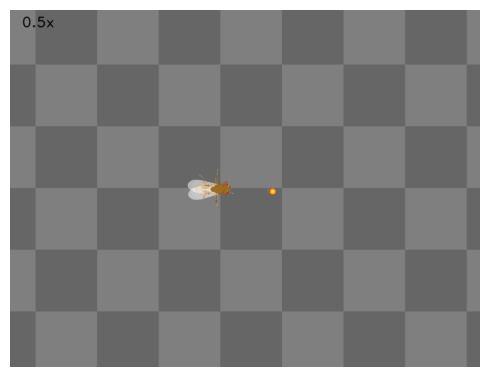

In [130]:
from pathlib import Path
import matplotlib.pyplot as plt
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF


Path("./outputs").mkdir(exist_ok=True)


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)
for i in range(500):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")


See the motion

In [131]:

from tqdm import trange

# Gains for the  odors (negative = attractive)
gains = np.array([-500,0])
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset(seed)
for i in trange(num_decision_steps):
    I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
    I = np.average(I_reshaped, axis=1, weights=[120, 1200])

    # Calculate the left-right asymmetry in the odor intensities
    I_l, I_r = I[:, 0], I[:, 1]
    denom = (I_l + I_r) / 2
    denom[denom == 0] = 1  # Avoid division by zero
    delta_I = (I_l - I_r) / denom

    # Calculate the weighted sum of the asymmetries for each odor
    s = np.dot(gains, delta_I)

    # Calculate the turning bias
    b = np.tanh(s**2)

    control_signal = np.ones((2,))
    side_to_modulate = int(s > 0)
    modulation_amount = b * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

    # Stop when the fly is within 2mm of the attractive odor source
    #if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 1:
    #    break




100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


In [132]:
sim.save_video("./outputs/odor_taxis_6.mp4")

from IPython import display

display.Video("./outputs/odor_taxis_6.mp4")